In [1]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import moment, binned_statistic

%config InlineBacked.figure_format='retina'

In [2]:
# helper functions
def coarse_grain(matrix, block_size=(2,2), method='mean'):
    """
    Coarse-grain a 2D matrix by applying block-wise reduction.

    Parameters
    ----------
    matrix : np.ndarray
        Input 2D array.
    block_size : tuple of int
        The (row_block, col_block) size to reduce over.
    method : {'mean', 'sum', 'max', 'min'}
        Reduction method.

    Returns
    -------
    reduced : np.ndarray
        Coarse-grained 2D array.
    """
    m, n = matrix.shape
    br, bc = block_size

    # Trim so dimensions are multiples of block size
    m2 = (m // br) * br
    n2 = (n // bc) * bc
    mat = matrix[:m2, :n2]

    # Reshape into blocks
    mat_reshaped = mat.reshape(m2//br, br, n2//bc, bc)

    # Apply reduction
    if method == 'mean':
        return mat_reshaped.mean(axis=(1,3))
    elif method == 'sum':
        return mat_reshaped.sum(axis=(1,3))
    elif method == 'max':
        return mat_reshaped.max(axis=(1,3))
    elif method == 'min':
        return mat_reshaped.min(axis=(1,3))
    else:
        raise ValueError(f"Unknown method {method!r}")

def power_spectra(im):
    '''
    Computes the power spectra from Bert's blog. Only works for square images. 
    For plotting, plot the PSD in log log space with kvals on the x-axis and
    A-bins on the y-axis. 
    '''
    # (1) Convert image to numpy array if not already
    #im = np.array(im)
    d = int(len(im[0]))

    # (2) Get and flatten Fourier amplitudes. 
    fft_amps = (np.abs(np.fft.fft2(im))**2).flatten()

    # (3) Get and flatten the k-norms
    kfreq = np.fft.fftfreq(d) * d
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()

    # (4) Bin the amplitudes 
    kbins = np.arange(0.5, d//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = binned_statistic(knrm, fft_amps, statistic = 'mean', bins = kbins)

    # (5) Get the total power in each bin
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    return kvals, Abins


In [3]:
# open datasets
ds = xr.open_dataset('nextsimdg/run/benchmark_32x32.diagnostic.nc', group = 'data')
ds = ds.set_coords(["x", "y"])

# global defs
moments = ['m1', 'm2', 'm3']
kernel = [1, 2, 4, 8]
dx = ds['x'][0,1,0].values  - ds['x'][0,0,0].values
secsInADay = 24*3600
shear_rate_conversion = secsInADay # eh maybe not; maybe just need to ignore 0s

# visualize moments from a single timestep

In [4]:
timestep = 10
matrix = ds['shear'][timestep, :, :].values 
matrix = matrix*shear_rate_conversion
length_scale = np.array(kernel)*dx
A = np.empty((3,4)) # 3 x 4 matrix containing moments at each length scale
for j, k in enumerate(kernel):
    coarsened_matrix = coarse_grain(matrix, block_size=(k,k))
    for m in range(len(moments)):
        moment_num = m + 1
        if m == 0:
            A[m, j] = moment(np.ravel(coarsened_matrix), moment_num, center = 0)
        else:
            A[m, j] = moment(np.ravel(coarsened_matrix), moment_num)

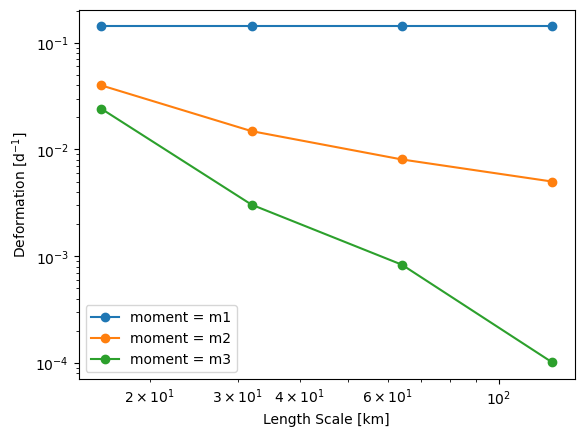

In [5]:
fig = plt.figure()
for i, m in enumerate(moments):
    plt.plot(length_scale/1000, A[i, :], 'o-', label = f'moment = {m}')
plt.legend()
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Length Scale [km]')
plt.ylabel('Deformation [d$^{-1}$]')
plt.show()

# look at spread of moments for all times

In [6]:
ntimes = len(ds['time'])
moments = ['m1', 'm2', 'm3']
kernel = [1, 2, 4, 8]
dx = ds['x'][0,10,11].values  - ds['x'][0,9,11].values
secsInADay = 24*3600
shear_rate_conversion = secsInADay # eh maybe not; maybe just need to ignore 0s

B = np.empty((ntimes, 3, 4))
for t in range(ntimes):
    matrix = ds['shear'][t, :, :].values 
    matrix = matrix*shear_rate_conversion
    length_scale = np.array(kernel)*dx
    for j, k in enumerate(kernel):
        coarsened_matrix = coarse_grain(matrix, block_size=(k,k))
        for m in range(len(moments)):
            moment_num = m + 1
            if m == 0:
                B[t, m, j] = moment(np.ravel(coarsened_matrix), moment_num, center = 0)
            else:
                B[t, m, j] = moment(np.ravel(coarsened_matrix), moment_num)

                
    

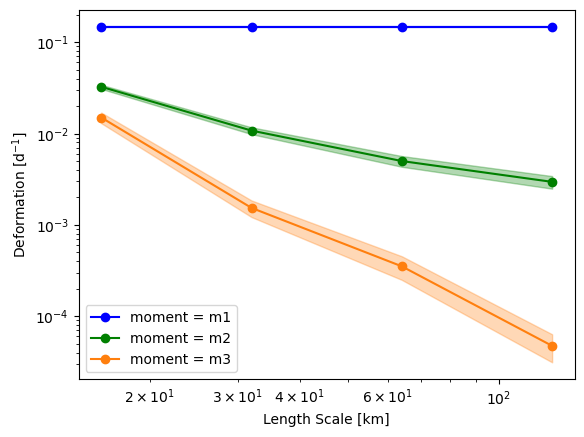

In [7]:
A_plot = np.mean(B, axis = 0)
A_err = np.sqrt(np.var(B, axis = 0)/(ntimes))

fig = plt.figure()
colors = ['blue', 'green', 'tab:orange']
for i, m in enumerate(moments):
    plt.plot(length_scale/1000, A_plot[i, :], 'o-', color = colors[i], label = f'moment = {m}')
    plt.fill_between(length_scale/1000, A_plot[i, :]-A_err[i,:], A_plot[i, :]+A_err[i,:], color = colors[i], alpha = 0.3)
plt.legend()
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Length Scale [km]')
plt.ylabel('Deformation [d$^{-1}$]')
plt.show()

# plot deformation stats for each time

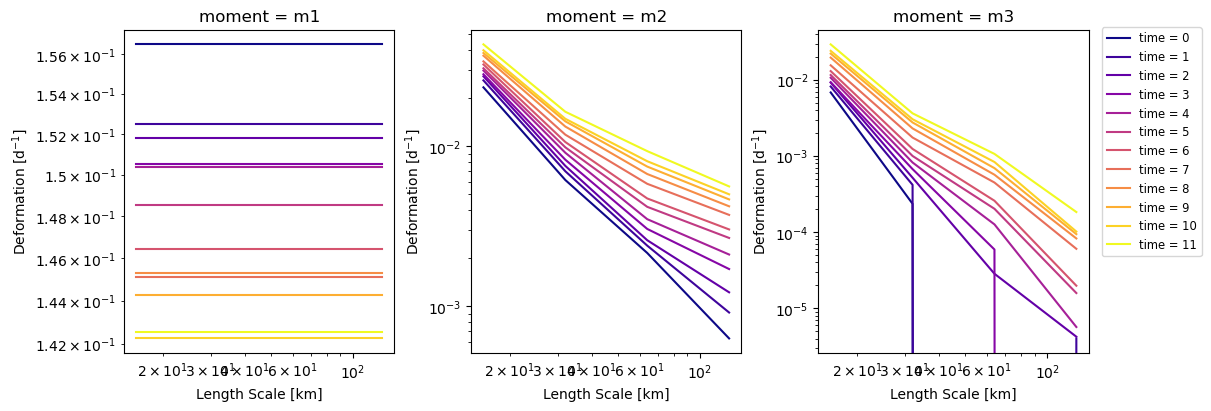

In [8]:
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0,1,ntimes))

fig,ax = plt.subplots(1,3, layout='constrained', figsize = (12,4))
for i, m in enumerate(moments):
    plt.sca(ax[i])
    for t in range(ntimes):
        plt.plot(length_scale/1000, B[t, i, :], color= colors[t], label = f'time = {t}')
    if i == 2:
        plt.legend(loc = (1.05, 0.3), fontsize = 'small')
    plt.title(f'moment = {m}')
    plt.xscale('log'), plt.yscale('log')
    plt.xlabel('Length Scale [km]')
    plt.ylabel('Deformation [d$^{-1}$]')
plt.show()

There's clearly a time evolution where higher values of the 2nd and 3rd moments are observed for later timesteps - kinda makes sense more variance in fractures. Though, the mean is lower for later time, which is not intuitive to me. The statistics are not stationary throughout the simulation, but they also shouldn't be expected to be stationary - we would want to see a temporal evolutoin as more fracture appear. How should time be handled in the mean sense? 

# try taking power spectrum? should also try structure functions

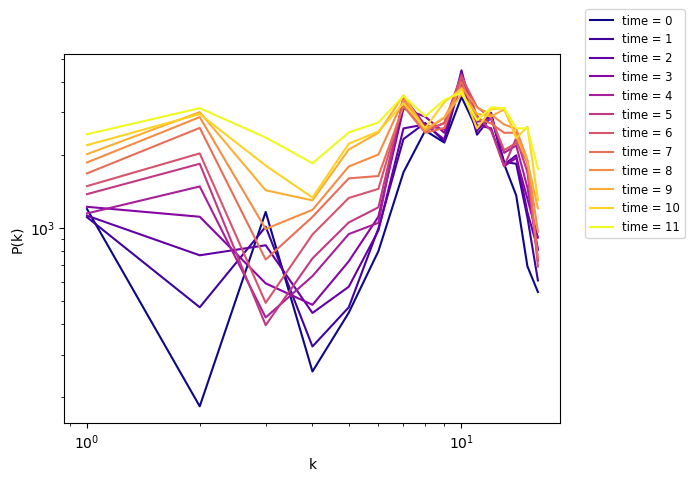

In [9]:
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0,1,ntimes))
fig = plt.figure()
for t in range(ntimes):
    matrix = ds['shear'][t, :, :].values 
    matrix = matrix*shear_rate_conversion
    kvals, Abins = power_spectra(matrix)
    plt.loglog(kvals, Abins, label = f'time = {t}', color = colors[t])
plt.ylabel('P(k)')
plt.xlabel('k')
plt.legend(loc = (1.05, 0.5), fontsize = 'small')
plt.show()

okay yeah that doesn't say anything